# IC_2: Backpropagation & Multi-Layer Perceptrons

**Duration:** 45 minutes
**Format:** Live coding with student participation
**Course:** CSC 422 - Machine and Deep Learning
**Module:** 2 - Neural Networks

---

## Learning Goals

By the end of this class, students will:
- **Visualize gradient flow** through multi-layer networks
- **Implement forward propagation** with multiple layers and activation functions
- **Code backpropagation from scratch** using the chain rule
- **Build a complete training loop** with loss tracking and visualization
- **Debug matrix dimensions** in neural network code
- **Understand weight initialization** and why it matters

---

## Timeline

- **0-8 min:** Hook - The Backpropagation "Aha!" Moment
- **8-20 min:** Building a 2-Layer MLP from Scratch
- **20-32 min:** Backpropagation Implementation
- **32-40 min:** Training Loop & Visualization
- **40-45 min:** Transition to CA3 & Key Takeaways

---

## Setup: Import Libraries

Run this cell first to import all necessary libraries.

In [13]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Reproducibility
np.random.seed(42)

print("✅ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

✅ Libraries imported successfully!
NumPy version: 2.3.2


---

# Part 1: The Backpropagation "Aha!" Moment (0-8 min)

**Goal:** Build intuition for how gradients flow backward through a network

## The Big Picture

**Forward Pass:** Data flows forward → predictions
```
Input → Hidden Layer → Output → Loss
  x   →   h = σ(Wx)  →   y   →  L
```

**Backward Pass:** Gradients flow backward → parameter updates
```
Loss → Output Gradient → Hidden Gradient → Weight Updates
 L  →      ∂L/∂y      →     ∂L/∂h      →   ∂L/∂W, ∂L/∂b
```

**Key Insight:** The chain rule connects everything!

In [2]:
# Simple example: Function composition
# f(x) = (2x + 3)^2
# Let's break this down: u = 2x + 3, then f = u^2

def forward_example(x):
    """Forward pass for f(x) = (2x + 3)^2"""
    u = 2*x + 3  # First operation
    f = u**2     # Second operation
    return f, u  # Return both for backward pass

def backward_example(x, u, f):
    """Backward pass using chain rule"""
    # Chain rule: df/dx = (df/du) * (du/dx)
    df_du = 2*u      # Derivative of u^2
    du_dx = 2        # Derivative of 2x + 3
    df_dx = df_du * du_dx  # Chain rule!
    return df_dx

# Test it
x_test = 1.0
f_val, u_val = forward_example(x_test)
gradient = backward_example(x_test, u_val, f_val)

print("=== CHAIN RULE EXAMPLE ===")
print(f"Input x = {x_test}")
print(f"Intermediate u = 2x + 3 = {u_val}")
print(f"Output f = u^2 = {f_val}")
print(f"Gradient df/dx = {gradient}")
print("\nThis is exactly what happens in backpropagation!")
print("Each layer passes gradients backward using the chain rule.")

=== CHAIN RULE EXAMPLE ===
Input x = 1.0
Intermediate u = 2x + 3 = 5.0
Output f = u^2 = 25.0
Gradient df/dx = 20.0

This is exactly what happens in backpropagation!
Each layer passes gradients backward using the chain rule.


## Visualize Gradient Flow

Let's visualize how information flows in both directions.

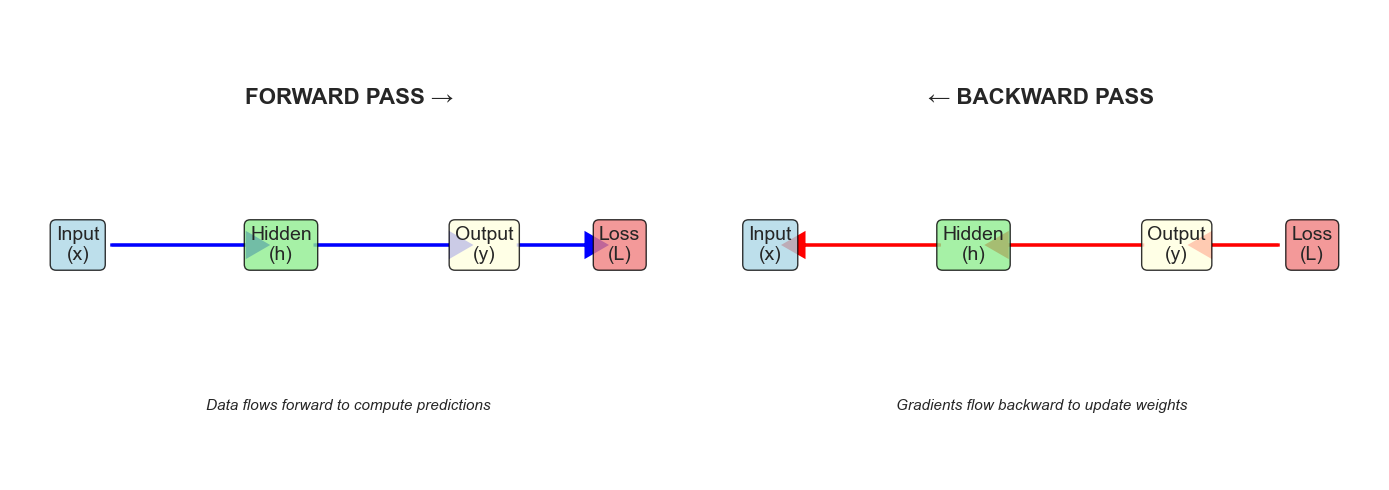

💡 Key Insight: Forward pass computes outputs, backward pass computes gradients!


In [14]:
# Create a simple 2-layer network visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Forward pass visualization
ax1.text(0.1, 0.5, 'Input\n(x)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax1.text(0.4, 0.5, 'Hidden\n(h)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax1.text(0.7, 0.5, 'Output\n(y)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax1.text(0.9, 0.5, 'Loss\n(L)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

ax1.arrow(0.15, 0.5, 0.2, 0, head_width=0.05, head_length=0.03, fc='blue', ec='blue', linewidth=2)
ax1.arrow(0.45, 0.5, 0.2, 0, head_width=0.05, head_length=0.03, fc='blue', ec='blue', linewidth=2)
ax1.arrow(0.75, 0.5, 0.1, 0, head_width=0.05, head_length=0.03, fc='blue', ec='blue', linewidth=2)

ax1.text(0.5, 0.8, 'FORWARD PASS →', fontsize=16, fontweight='bold', ha='center')
ax1.text(0.5, 0.15, 'Data flows forward to compute predictions', fontsize=11, ha='center', style='italic')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.axis('off')

# Backward pass visualization
ax2.text(0.1, 0.5, 'Input\n(x)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
ax2.text(0.4, 0.5, 'Hidden\n(h)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
ax2.text(0.7, 0.5, 'Output\n(y)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
ax2.text(0.9, 0.5, 'Loss\n(L)', fontsize=14, ha='center', va='center',
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))

ax2.arrow(0.85, 0.5, -0.1, 0, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=2)
ax2.arrow(0.65, 0.5, -0.2, 0, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=2)
ax2.arrow(0.35, 0.5, -0.2, 0, head_width=0.05, head_length=0.03, fc='red', ec='red', linewidth=2)

ax2.text(0.5, 0.8, '← BACKWARD PASS', fontsize=16, fontweight='bold', ha='center')
ax2.text(0.5, 0.15, 'Gradients flow backward to update weights', fontsize=11, ha='center', style='italic')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

plt.tight_layout()
plt.show()

print("💡 Key Insight: Forward pass computes outputs, backward pass computes gradients!")

---

# Part 2: Building a 2-Layer MLP from Scratch (8-20 min)

**Goal:** Implement the building blocks of a neural network

## Network Architecture

We'll build a simple 2-layer MLP:
- **Input Layer:** 2 features (for 2D visualization)
- **Hidden Layer:** 4 neurons with ReLU activation
- **Output Layer:** 1 neuron with sigmoid activation (binary classification)

```
Input (2) → Hidden (4) → Output (1)
   x₁        h₁          y
   x₂        h₂
             h₃
             h₄
```

## Step 1: Activation Functions

Let's implement the activation functions we'll need.

=== ACTIVATION FUNCTIONS ===
ReLU:
  Input:  [-2 -1  0  1  2]
  Output: [0 0 0 1 2]
  Deriv:  [0. 0. 0. 1. 1.]

Sigmoid:
  Input:  [-2 -1  0  1  2]
  Output: [0.11920292 0.26894142 0.5        0.73105858 0.88079708]
  Deriv:  [0.10499359 0.19661193 0.25       0.19661193 0.10499359]


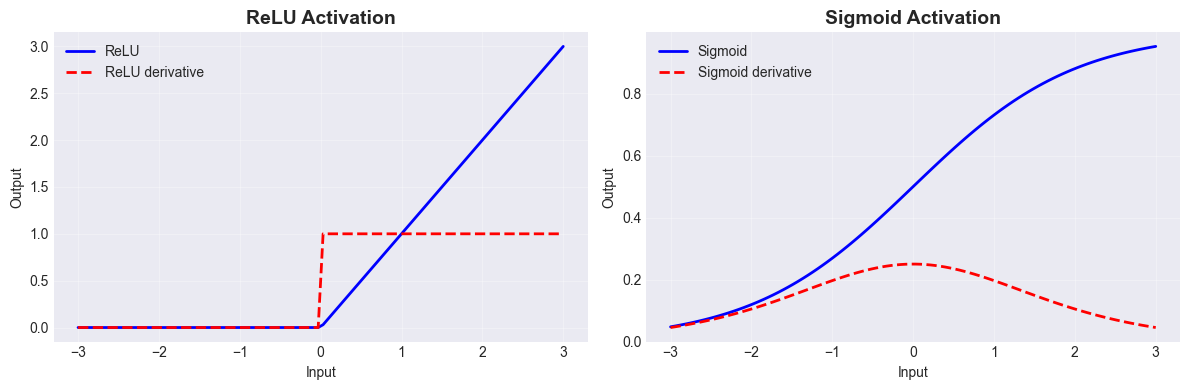

In [15]:
# Activation functions and their derivatives
def relu(x):
    """ReLU activation function"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU"""
    return (x > 0).astype(float)

def sigmoid(x):
    """Sigmoid activation function"""
    # Clip x to prevent overflow
    x = np.clip(x, -500, 500)
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    """Derivative of sigmoid"""
    s = sigmoid(x)
    return s * (1 - s)

# Test the functions
print("=== ACTIVATION FUNCTIONS ===")
test_vals = np.array([-2, -1, 0, 1, 2])

print("ReLU:")
print(f"  Input:  {test_vals}")
print(f"  Output: {relu(test_vals)}")
print(f"  Deriv:  {relu_derivative(test_vals)}")

print("\nSigmoid:")
print(f"  Input:  {test_vals}")
print(f"  Output: {sigmoid(test_vals)}")
print(f"  Deriv:  {sigmoid_derivative(test_vals)}")

# Visualize activation functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

x = np.linspace(-3, 3, 100)

# ReLU
ax1.plot(x, relu(x), 'b-', linewidth=2, label='ReLU')
ax1.plot(x, relu_derivative(x), 'r--', linewidth=2, label='ReLU derivative')
ax1.set_title('ReLU Activation', fontsize=14, fontweight='bold')
ax1.set_xlabel('Input')
ax1.set_ylabel('Output')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sigmoid
ax2.plot(x, sigmoid(x), 'b-', linewidth=2, label='Sigmoid')
ax2.plot(x, sigmoid_derivative(x), 'r--', linewidth=2, label='Sigmoid derivative')
ax2.set_title('Sigmoid Activation', fontsize=14, fontweight='bold')
ax2.set_xlabel('Input')
ax2.set_ylabel('Output')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

## Step 2: Initialize Network Parameters

Let's create our network weights and biases with proper initialization.

=== INITIALIZING NETWORK PARAMETERS ===
W1 shape: (2, 4) (input → hidden)
b1 shape: (1, 4)
W2 shape: (4, 1) (hidden → output)
b2 shape: (1, 1)

W1 (input to hidden weights):
[[-0.25091976  0.90142861  0.46398788  0.19731697]
 [-0.68796272 -0.68801096 -0.88383278  0.73235229]]

W2 (hidden to output weights):
[[ 0.22153189]
 [ 0.45586418]
 [-1.05034675]
 [ 1.0295209 ]]


/var/folders/v9/6w8jy2t10jbgv_kq35fwtd29d4vj27/T/ipykernel_82990/1675585937.py:58: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/6w8jy2t10jbgv_kq35fwtd29d4vj27/T/ipykernel_82990/1675585937.py:58: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/rmoseley/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rmoseley/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


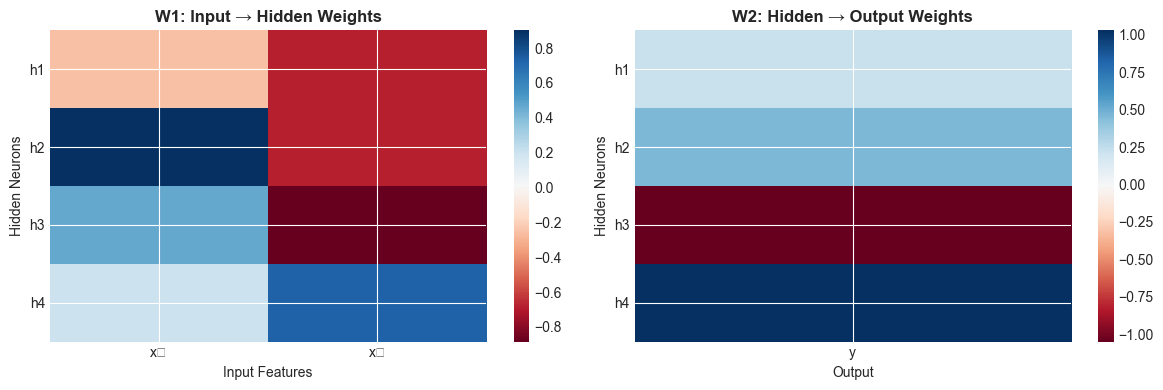

✅ Network parameters initialized!


In [16]:
# Network parameters
input_size = 2     # 2 features (x1, x2)
hidden_size = 4    # 4 hidden neurons
output_size = 1    # 1 output (binary classification)

# Initialize weights using Xavier initialization
def xavier_init(fan_in, fan_out):
    """Xavier weight initialization"""
    limit = np.sqrt(6.0 / (fan_in + fan_out))
    return np.random.uniform(-limit, limit, (fan_in, fan_out))

# Initialize parameters
print("=== INITIALIZING NETWORK PARAMETERS ===")

# Hidden layer parameters
W1 = xavier_init(input_size, hidden_size)
b1 = np.zeros((1, hidden_size))

# Output layer parameters
W2 = xavier_init(hidden_size, output_size)
b2 = np.zeros((1, output_size))

print(f"W1 shape: {W1.shape} (input → hidden)")
print(f"b1 shape: {b1.shape}")
print(f"W2 shape: {W2.shape} (hidden → output)")
print(f"b2 shape: {b2.shape}")

print(f"\nW1 (input to hidden weights):")
print(W1)
print(f"\nW2 (hidden to output weights):")
print(W2)

# Visualize initial weights
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# W1 visualization
im1 = ax1.imshow(W1.T, cmap='RdBu', aspect='auto')
ax1.set_title('W1: Input → Hidden Weights', fontweight='bold')
ax1.set_xlabel('Input Features')
ax1.set_ylabel('Hidden Neurons')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['x₁', 'x₂'])
ax1.set_yticks(range(hidden_size))
ax1.set_yticklabels([f'h{i+1}' for i in range(hidden_size)])
plt.colorbar(im1, ax=ax1)

# W2 visualization
im2 = ax2.imshow(W2, cmap='RdBu', aspect='auto')
ax2.set_title('W2: Hidden → Output Weights', fontweight='bold')
ax2.set_xlabel('Output')
ax2.set_ylabel('Hidden Neurons')
ax2.set_xticks([0])
ax2.set_xticklabels(['y'])
ax2.set_yticks(range(hidden_size))
ax2.set_yticklabels([f'h{i+1}' for i in range(hidden_size)])
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("✅ Network parameters initialized!")

## Step 3: Forward Propagation

Now let's implement the forward pass through our network.

In [17]:
def forward_propagation(X, W1, b1, W2, b2):
    """
    Forward propagation through the 2-layer MLP
    
    Args:
        X: Input data (batch_size, input_size)
        W1, b1: Hidden layer weights and biases
        W2, b2: Output layer weights and biases
    
    Returns:
        y_pred: Final predictions
        cache: Intermediate values for backpropagation
    """
    # Layer 1: Input → Hidden
    z1 = X @ W1 + b1                    # Linear transformation
    a1 = relu(z1)                       # ReLU activation
    
    # Layer 2: Hidden → Output
    z2 = a1 @ W2 + b2                   # Linear transformation
    y_pred = sigmoid(z2)                # Sigmoid activation
    
    # Cache intermediate values for backpropagation
    cache = {
        'X': X,
        'z1': z1, 'a1': a1,
        'z2': z2, 'y_pred': y_pred
    }
    
    return y_pred, cache

# Test forward propagation with sample data
print("=== TESTING FORWARD PROPAGATION ===")

# Create sample input
X_sample = np.array([[1.0, 0.5],
                     [-0.5, 1.0],
                     [0.0, -1.0]])

print(f"Input X shape: {X_sample.shape}")
print(f"Input X:")
print(X_sample)

# Forward pass
y_pred, cache = forward_propagation(X_sample, W1, b1, W2, b2)

print(f"\nHidden layer (z1) shape: {cache['z1'].shape}")
print(f"Hidden activations (a1) shape: {cache['a1'].shape}")
print(f"Output layer (z2) shape: {cache['z2'].shape}")
print(f"Predictions (y_pred) shape: {y_pred.shape}")

print(f"\nHidden layer pre-activation (z1):")
print(cache['z1'])
print(f"\nHidden layer activations (a1):")
print(cache['a1'])
print(f"\nOutput layer pre-activation (z2):")
print(cache['z2'])
print(f"\nFinal predictions (y_pred):")
print(y_pred)

print("✅ Forward propagation working!")

=== TESTING FORWARD PROPAGATION ===
Input X shape: (3, 2)
Input X:
[[ 1.   0.5]
 [-0.5  1. ]
 [ 0.  -1. ]]

Hidden layer (z1) shape: (3, 4)
Hidden activations (a1) shape: (3, 4)
Output layer (z2) shape: (3, 1)
Predictions (y_pred) shape: (3, 1)

Hidden layer pre-activation (z1):
[[-0.59490112  0.55742313  0.0220715   0.56349311]
 [-0.56250284 -1.13872527 -1.11582672  0.63369381]
 [ 0.68796272  0.68801096  0.88383278 -0.73235229]]

Hidden layer activations (a1):
[[0.         0.55742313 0.0220715  0.56349311]
 [0.         0.         0.         0.63369381]
 [0.68796272 0.68801096 0.88383278 0.        ]]

Output layer pre-activation (z2):
[[ 0.81105445]
 [ 0.65240102]
 [-0.46228565]]

Final predictions (y_pred):
[[0.69233416]
 [0.65755132]
 [0.38644374]]
✅ Forward propagation working!


---

# Part 3: Backpropagation Implementation (20-32 min)

**Goal:** Implement the backpropagation algorithm from scratch

## The Mathematics

For our 2-layer network, we need to compute gradients using the chain rule:

**Loss Function:** Binary Cross-Entropy
```
L = -[y log(ŷ) + (1-y) log(1-ŷ)]
```

**Gradient Flow:**
```
∂L/∂W2 = ∂L/∂z2 × ∂z2/∂W2
∂L/∂W1 = ∂L/∂z2 × ∂z2/∂a1 × ∂a1/∂z1 × ∂z1/∂W1
```

## Step 1: Loss Function

First, let's implement the binary cross-entropy loss function.

=== TESTING LOSS FUNCTION ===
True labels: [1 0 1]
Predictions: [0.8 0.3 0.9]
Loss: 0.2284
Loss gradient: [-0.41666667  0.47619048 -0.37037037]


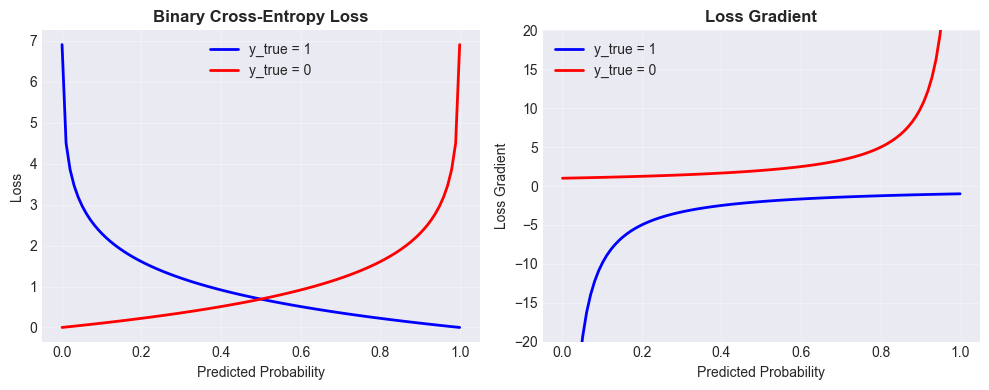

✅ Loss function implemented!


In [18]:
def binary_cross_entropy_loss(y_true, y_pred):
    """
    Compute binary cross-entropy loss
    
    Args:
        y_true: True labels (batch_size, 1)
        y_pred: Predicted probabilities (batch_size, 1)
    
    Returns:
        loss: Average loss across the batch
    """
    # Clip predictions to prevent log(0)
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
    # Compute binary cross-entropy
    loss = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    return loss

def loss_derivative(y_true, y_pred):
    """
    Compute derivative of binary cross-entropy loss w.r.t. predictions
    
    Args:
        y_true: True labels (batch_size, 1)
        y_pred: Predicted probabilities (batch_size, 1)
    
    Returns:
        dL_dy_pred: Gradient of loss w.r.t. predictions
    """
    # Clip predictions to prevent division by 0
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    
    # Derivative of binary cross-entropy
    dL_dy_pred = -(y_true / y_pred - (1 - y_true) / (1 - y_pred))
    
    return dL_dy_pred / len(y_true)  # Average over batch

# Test loss function
print("=== TESTING LOSS FUNCTION ===")

# Create sample targets
y_true_sample = np.array([[1], [0], [1]])
y_pred_sample = np.array([[0.8], [0.3], [0.9]])

print(f"True labels: {y_true_sample.flatten()}")
print(f"Predictions: {y_pred_sample.flatten()}")

loss = binary_cross_entropy_loss(y_true_sample, y_pred_sample)
loss_grad = loss_derivative(y_true_sample, y_pred_sample)

print(f"Loss: {loss:.4f}")
print(f"Loss gradient: {loss_grad.flatten()}")

# Visualize loss function
y_pred_range = np.linspace(0.001, 0.999, 100)
loss_y1 = [-np.log(p) for p in y_pred_range]  # When y_true = 1
loss_y0 = [-np.log(1-p) for p in y_pred_range]  # When y_true = 0

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(y_pred_range, loss_y1, 'b-', linewidth=2, label='y_true = 1')
plt.plot(y_pred_range, loss_y0, 'r-', linewidth=2, label='y_true = 0')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss')
plt.title('Binary Cross-Entropy Loss', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
grad_y1 = [-1/p for p in y_pred_range]  # When y_true = 1
grad_y0 = [1/(1-p) for p in y_pred_range]  # When y_true = 0
plt.plot(y_pred_range, grad_y1, 'b-', linewidth=2, label='y_true = 1')
plt.plot(y_pred_range, grad_y0, 'r-', linewidth=2, label='y_true = 0')
plt.xlabel('Predicted Probability')
plt.ylabel('Loss Gradient')
plt.title('Loss Gradient', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-20, 20)

plt.tight_layout()
plt.show()

print("✅ Loss function implemented!")

## Step 2: Backpropagation Algorithm

Now for the main event - implementing backpropagation! 🎯

=== TESTING BACKPROPAGATION ===
Gradient shapes:
  dW2: (4, 1)
  db2: (1, 1)
  dW1: (2, 4)
  db1: (1, 4)
  dz2: (3, 1)
  dz1: (3, 4)

Output layer gradients:
  dW2:
[[-0.14070128]
 [-0.19787783]
 [-0.18302392]
 [ 0.08110621]]
  db2: [[-0.08789026]]

Hidden layer gradients:
  dW1:
[[ 0.         -0.04675128  0.10771861 -0.21840994]
 [ 0.04530743  0.06985713 -0.1609563   0.17286287]]
  db1: [[-0.04530743 -0.13998405  0.32253421  0.12007147]]


/var/folders/v9/6w8jy2t10jbgv_kq35fwtd29d4vj27/T/ipykernel_82990/2533898220.py:113: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/v9/6w8jy2t10jbgv_kq35fwtd29d4vj27/T/ipykernel_82990/2533898220.py:113: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/rmoseley/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/rmoseley/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


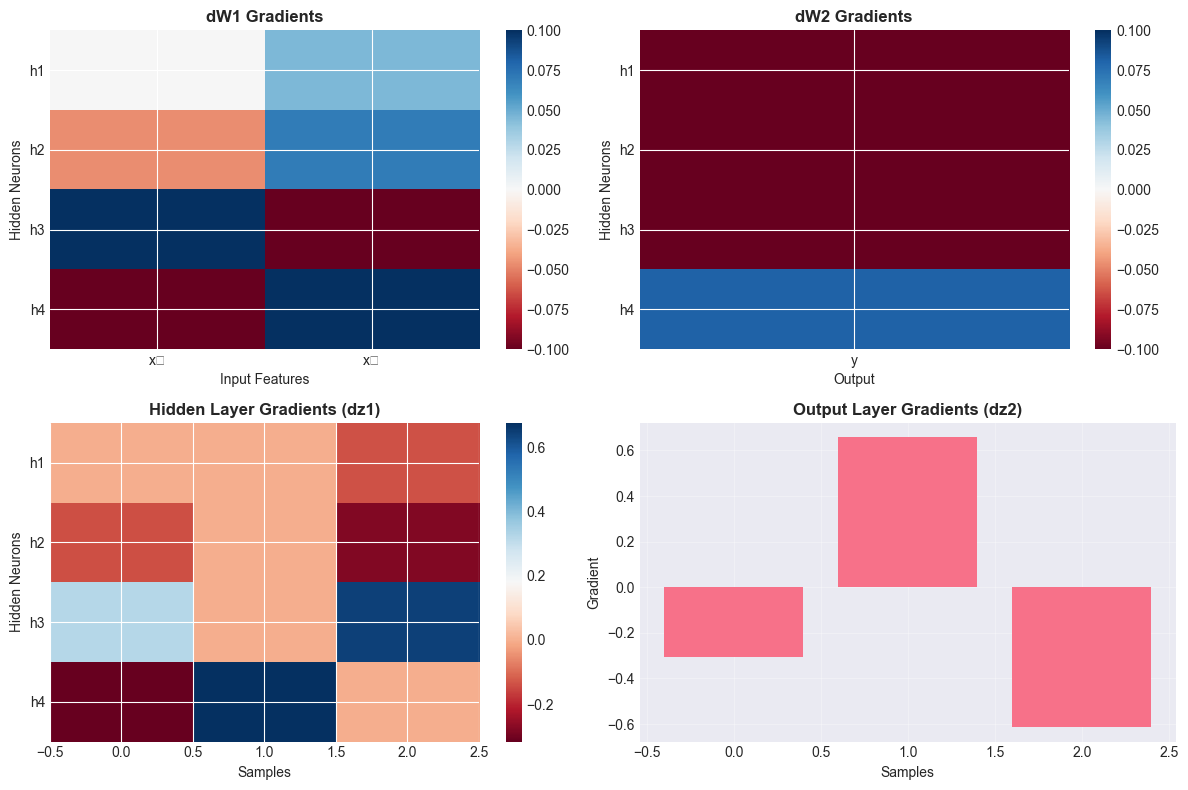

✅ Backpropagation implemented!


In [19]:
def backward_propagation(y_true, cache):
    """
    Backpropagation through the 2-layer MLP
    
    Args:
        y_true: True labels (batch_size, 1)
        cache: Intermediate values from forward pass
    
    Returns:
        gradients: Dictionary containing all gradients
    """
    # Extract values from cache
    X = cache['X']
    z1, a1 = cache['z1'], cache['a1']
    z2, y_pred = cache['z2'], cache['y_pred']
    
    m = X.shape[0]  # batch size
    
    # ======================
    # OUTPUT LAYER GRADIENTS
    # ======================
    
    # Gradient of loss w.r.t. output layer pre-activation (z2)
    # For sigmoid + binary cross-entropy, this simplifies to:
    dz2 = y_pred - y_true  # This is the magic of sigmoid + BCE!
    
    # Gradients w.r.t. output layer parameters
    dW2 = (1/m) * (a1.T @ dz2)  # (hidden_size, 1)
    db2 = (1/m) * np.sum(dz2, axis=0, keepdims=True)  # (1, 1)
    
    # ======================
    # HIDDEN LAYER GRADIENTS
    # ======================
    
    # Gradient w.r.t. hidden layer activations (a1)
    da1 = dz2 @ W2.T  # (batch_size, hidden_size)
    
    # Gradient w.r.t. hidden layer pre-activations (z1)
    dz1 = da1 * relu_derivative(z1)  # Element-wise multiplication
    
    # Gradients w.r.t. hidden layer parameters
    dW1 = (1/m) * (X.T @ dz1)  # (input_size, hidden_size)
    db1 = (1/m) * np.sum(dz1, axis=0, keepdims=True)  # (1, hidden_size)
    
    # Package gradients
    gradients = {
        'dW2': dW2, 'db2': db2,
        'dW1': dW1, 'db1': db1,
        'dz2': dz2, 'dz1': dz1  # For visualization
    }
    
    return gradients

# Test backpropagation
print("=== TESTING BACKPROPAGATION ===")

# Use our previous forward pass results
gradients = backward_propagation(y_true_sample, cache)

print("Gradient shapes:")
for key, grad in gradients.items():
    print(f"  {key}: {grad.shape}")

print(f"\nOutput layer gradients:")
print(f"  dW2:\n{gradients['dW2']}")
print(f"  db2: {gradients['db2']}")

print(f"\nHidden layer gradients:")
print(f"  dW1:\n{gradients['dW1']}")
print(f"  db1: {gradients['db1']}")

# Visualize gradients
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# dW1 gradients
im1 = ax1.imshow(gradients['dW1'].T, cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)
ax1.set_title('dW1 Gradients', fontweight='bold')
ax1.set_xlabel('Input Features')
ax1.set_ylabel('Hidden Neurons')
ax1.set_xticks([0, 1])
ax1.set_xticklabels(['x₁', 'x₂'])
ax1.set_yticks(range(hidden_size))
ax1.set_yticklabels([f'h{i+1}' for i in range(hidden_size)])
plt.colorbar(im1, ax=ax1)

# dW2 gradients
im2 = ax2.imshow(gradients['dW2'], cmap='RdBu', aspect='auto', vmin=-0.1, vmax=0.1)
ax2.set_title('dW2 Gradients', fontweight='bold')
ax2.set_xlabel('Output')
ax2.set_ylabel('Hidden Neurons')
ax2.set_xticks([0])
ax2.set_xticklabels(['y'])
ax2.set_yticks(range(hidden_size))
ax2.set_yticklabels([f'h{i+1}' for i in range(hidden_size)])
plt.colorbar(im2, ax=ax2)

# Hidden layer gradients (dz1)
im3 = ax3.imshow(gradients['dz1'].T, cmap='RdBu', aspect='auto')
ax3.set_title('Hidden Layer Gradients (dz1)', fontweight='bold')
ax3.set_xlabel('Samples')
ax3.set_ylabel('Hidden Neurons')
ax3.set_yticks(range(hidden_size))
ax3.set_yticklabels([f'h{i+1}' for i in range(hidden_size)])
plt.colorbar(im3, ax=ax3)

# Output layer gradients (dz2)
ax4.bar(range(len(gradients['dz2'])), gradients['dz2'].flatten())
ax4.set_title('Output Layer Gradients (dz2)', fontweight='bold')
ax4.set_xlabel('Samples')
ax4.set_ylabel('Gradient')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Backpropagation implemented!")

---

# Part 4: Training Loop & Visualization (32-40 min)

**Goal:** Put it all together and train our neural network on real data!

## Create Training Data

Let's use the classic "moons" dataset for binary classification.

=== CREATING TRAINING DATA ===
Training data shape: X=(240, 2), y=(240, 1)
Test data shape: X=(60, 2), y=(60, 1)


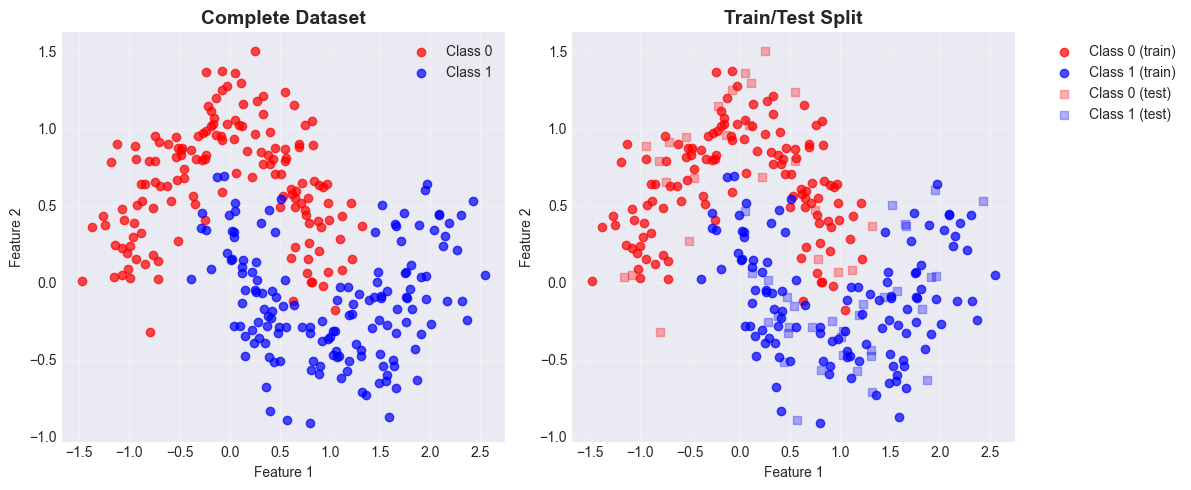

✅ Dataset created and visualized!


In [20]:
# Generate the moons dataset
print("=== CREATING TRAINING DATA ===")

# Generate data
X, y = make_moons(n_samples=300, noise=0.2, random_state=42)
y = y.reshape(-1, 1)  # Reshape for our network

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: X={X_train.shape}, y={y_train.shape}")
print(f"Test data shape: X={X_test.shape}, y={y_test.shape}")

# Visualize the dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X[y.flatten()==0, 0], X[y.flatten()==0, 1], c='red', alpha=0.7, label='Class 0')
plt.scatter(X[y.flatten()==1, 0], X[y.flatten()==1, 1], c='blue', alpha=0.7, label='Class 1')
plt.title('Complete Dataset', fontweight='bold', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(X_train[y_train.flatten()==0, 0], X_train[y_train.flatten()==0, 1], 
           c='red', alpha=0.7, label='Class 0 (train)')
plt.scatter(X_train[y_train.flatten()==1, 0], X_train[y_train.flatten()==1, 1], 
           c='blue', alpha=0.7, label='Class 1 (train)')
plt.scatter(X_test[y_test.flatten()==0, 0], X_test[y_test.flatten()==0, 1], 
           c='red', alpha=0.3, marker='s', label='Class 0 (test)')
plt.scatter(X_test[y_test.flatten()==1, 0], X_test[y_test.flatten()==1, 1], 
           c='blue', alpha=0.3, marker='s', label='Class 1 (test)')
plt.title('Train/Test Split', fontweight='bold', fontsize=14)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Dataset created and visualized!")

## Complete Training Loop

Now let's implement the full training loop with gradient descent!

In [21]:
def train_network(X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.1):
    """Complete training loop for our 2-layer MLP"""
    
    # Re-initialize network parameters for fresh training
    W1 = xavier_init(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = xavier_init(hidden_size, output_size)
    b2 = np.zeros((1, output_size))
    
    # Track training progress
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    print("=== TRAINING NEURAL NETWORK ===")
    print(f"Epochs: {epochs}, Learning Rate: {learning_rate}")
    print(f"Architecture: {input_size} → {hidden_size} → {output_size}")
    print()
    
    for epoch in range(epochs):
        # Forward pass
        y_pred_train, cache = forward_propagation(X_train, W1, b1, W2, b2)
        train_loss = binary_cross_entropy_loss(y_train, y_pred_train)
        
        # Backward pass
        gradients = backward_propagation(y_train, cache)
        
        # Update parameters
        W1 -= learning_rate * gradients['dW1']
        b1 -= learning_rate * gradients['db1']
        W2 -= learning_rate * gradients['dW2']
        b2 -= learning_rate * gradients['db2']
        
        # Evaluate every 100 epochs
        if epoch % 100 == 0:
            y_pred_test, _ = forward_propagation(X_test, W1, b1, W2, b2)
            test_loss = binary_cross_entropy_loss(y_test, y_pred_test)
            
            train_acc = np.mean((y_pred_train > 0.5) == y_train)
            test_acc = np.mean((y_pred_test > 0.5) == y_test)
            
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            train_accuracies.append(train_acc)
            test_accuracies.append(test_acc)
            
            print(f"Epoch {epoch:4d}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
                  f"Train Acc: {train_acc:.3f}, Test Acc: {test_acc:.3f}")
    
    # Final evaluation
    y_pred_train_final, _ = forward_propagation(X_train, W1, b1, W2, b2)
    y_pred_test_final, _ = forward_propagation(X_test, W1, b1, W2, b2)
    
    final_train_acc = np.mean((y_pred_train_final > 0.5) == y_train)
    final_test_acc = np.mean((y_pred_test_final > 0.5) == y_test)
    
    print(f"\n🎯 FINAL RESULTS:")
    print(f"   Training Accuracy: {final_train_acc:.3f}")
    print(f"   Test Accuracy: {final_test_acc:.3f}")
    
    history = {
        'train_losses': train_losses, 'test_losses': test_losses,
        'train_accuracies': train_accuracies, 'test_accuracies': test_accuracies,
        'epochs_tracked': list(range(0, epochs, 100))
    }
    
    return W1, b1, W2, b2, history

# Train the network!
W1_trained, b1_trained, W2_trained, b2_trained, history = train_network(
    X_train, y_train, X_test, y_test, epochs=1000, learning_rate=0.5
)

=== TRAINING NEURAL NETWORK ===
Epochs: 1000, Learning Rate: 0.5
Architecture: 2 → 4 → 1

Epoch    0: Train Loss: 0.6069, Test Loss: 0.5865, Train Acc: 0.758, Test Acc: 0.883
Epoch  100: Train Loss: 0.3136, Test Loss: 0.2517, Train Acc: 0.858, Test Acc: 0.900
Epoch  200: Train Loss: 0.3018, Test Loss: 0.2534, Train Acc: 0.863, Test Acc: 0.900
Epoch  300: Train Loss: 0.2938, Test Loss: 0.2522, Train Acc: 0.871, Test Acc: 0.883
Epoch  400: Train Loss: 0.2920, Test Loss: 0.2514, Train Acc: 0.875, Test Acc: 0.883
Epoch  500: Train Loss: 0.2909, Test Loss: 0.2505, Train Acc: 0.875, Test Acc: 0.883
Epoch  600: Train Loss: 0.2892, Test Loss: 0.2494, Train Acc: 0.875, Test Acc: 0.883
Epoch  700: Train Loss: 0.2870, Test Loss: 0.2486, Train Acc: 0.875, Test Acc: 0.883
Epoch  800: Train Loss: 0.2847, Test Loss: 0.2471, Train Acc: 0.875, Test Acc: 0.883
Epoch  900: Train Loss: 0.2824, Test Loss: 0.2451, Train Acc: 0.879, Test Acc: 0.883

🎯 FINAL RESULTS:
   Training Accuracy: 0.879
   Test Accura

## Visualize Training Progress

Let's see how our network learned!

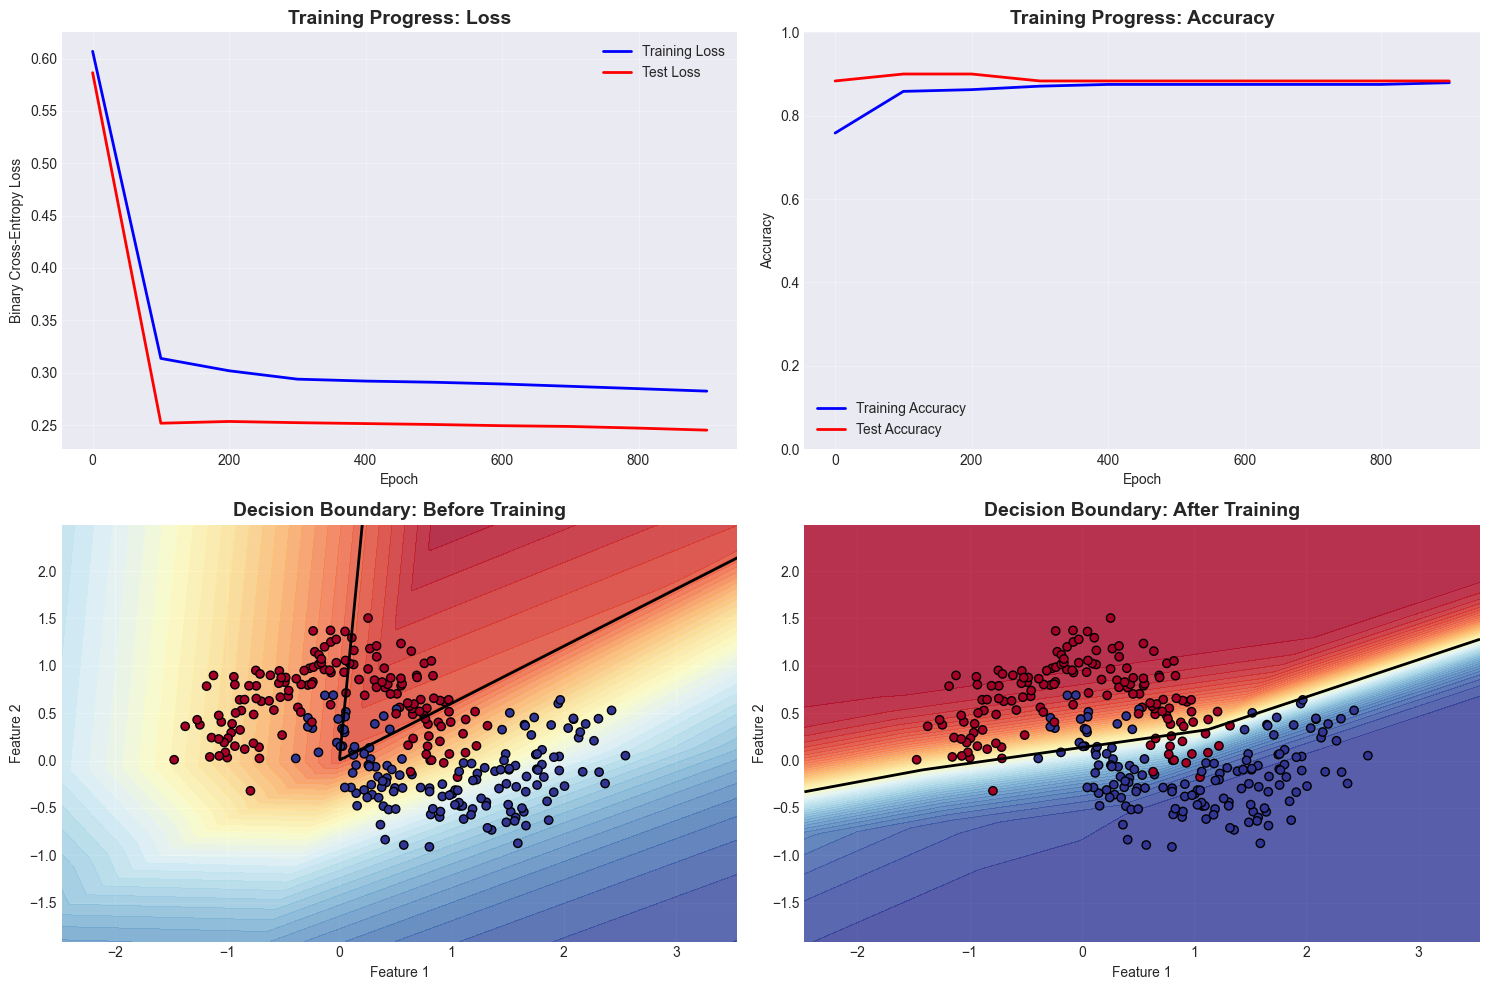

🎉 Training complete! Notice how the network learned to separate the two classes!


In [22]:
# Plot training progress
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

epochs_tracked = history['epochs_tracked']

# Loss curves
ax1.plot(epochs_tracked, history['train_losses'], 'b-', linewidth=2, label='Training Loss')
ax1.plot(epochs_tracked, history['test_losses'], 'r-', linewidth=2, label='Test Loss')
ax1.set_title('Training Progress: Loss', fontweight='bold', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Binary Cross-Entropy Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(epochs_tracked, history['train_accuracies'], 'b-', linewidth=2, label='Training Accuracy')
ax2.plot(epochs_tracked, history['test_accuracies'], 'r-', linewidth=2, label='Test Accuracy')
ax2.set_title('Training Progress: Accuracy', fontweight='bold', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

# Visualize decision boundary
def plot_decision_boundary(X, y, W1, b1, W2, b2, ax, title):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    Z, _ = forward_propagation(grid_points, W1, b1, W2, b2)
    Z = Z.reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=50, alpha=0.8, cmap=plt.cm.RdYlBu)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolors='black')
    ax.set_title(title, fontweight='bold', fontsize=14)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')

# Before training (using original random weights)
W1_random = xavier_init(input_size, hidden_size)
b1_random = np.zeros((1, hidden_size))
W2_random = xavier_init(hidden_size, output_size)
b2_random = np.zeros((1, output_size))

plot_decision_boundary(X, y, W1_random, b1_random, W2_random, b2_random, ax3, 
                      'Decision Boundary: Before Training')

# After training
plot_decision_boundary(X, y, W1_trained, b1_trained, W2_trained, b2_trained, ax4, 
                      'Decision Boundary: After Training')

plt.tight_layout()
plt.show()

print("🎉 Training complete! Notice how the network learned to separate the two classes!")

---

# Part 5: Key Takeaways & Transition to CA3 (40-45 min)

**Goal:** Solidify understanding and prepare students for their assignment

## What We've Accomplished Today 🎯

✅ **Built intuition** for gradient flow in neural networks  
✅ **Implemented forward propagation** with multiple layers  
✅ **Coded backpropagation from scratch** using the chain rule  
✅ **Created a complete training loop** with real data  
✅ **Visualized the learning process** and decision boundaries

## Key Insights

### 1. The Chain Rule is Everything
```
∂L/∂W₁ = ∂L/∂z₂ × ∂z₂/∂a₁ × ∂a₁/∂z₁ × ∂z₁/∂W₁
```
Each layer passes gradients backward, just like passing a message!

### 2. Matrix Dimensions Matter
- Always check your shapes: `(batch_size, features) @ (features, neurons)`
- Gradients have the same shape as the original parameters
- Use `.T` (transpose) strategically for proper matrix multiplication

### 3. Activation Functions Shape Learning
- **ReLU**: Fast, avoids vanishing gradients, but can "die" (output 0)
- **Sigmoid**: Smooth, good for binary classification, but can saturate
- **Choice matters** for your specific problem!

## Looking Ahead: CA3 Assignment 🚀

In **CA3: Neural Networks**, you'll:

1. **Extend today's work** to deeper networks with more hidden layers
2. **Implement different activation functions** (tanh, ReLU variations)
3. **Work with multi-class classification** (Wine dataset, 3 classes)
4. **Compare your implementation** with PyTorch's automatic differentiation
5. **Analyze hyperparameter effects** (learning rate, architecture, initialization)

### Preview: What's Different in CA3?

- **More layers**: You'll build 2-3 hidden layer networks
- **Multi-class output**: Softmax activation instead of sigmoid
- **Categorical cross-entropy**: Different loss function for multi-class
- **PyTorch comparison**: See how frameworks make this easier!

### Tips for Success

1. **Start with our code today** - it's your foundation!
2. **Test each component separately** - forward pass, then backward pass
3. **Use small networks first** - debug with 2-3 neurons per layer
4. **Visualize everything** - plots help you understand what's happening
5. **Check gradients numerically** - verify your backprop is correct

## Questions & Discussion 🤔

What questions do you have about:
- The backpropagation algorithm?
- Matrix dimensions and operations?
- Training loop implementation?
- Extending to deeper networks?

=== WEIGHT EVOLUTION ANALYSIS ===
Weight changes during training:
W1 initial range: [-0.884, 0.901]
W1 final range:   [-1.227, 1.632]
W2 initial range: [-1.050, 1.030]
W2 final range:   [-1.939, 2.297]


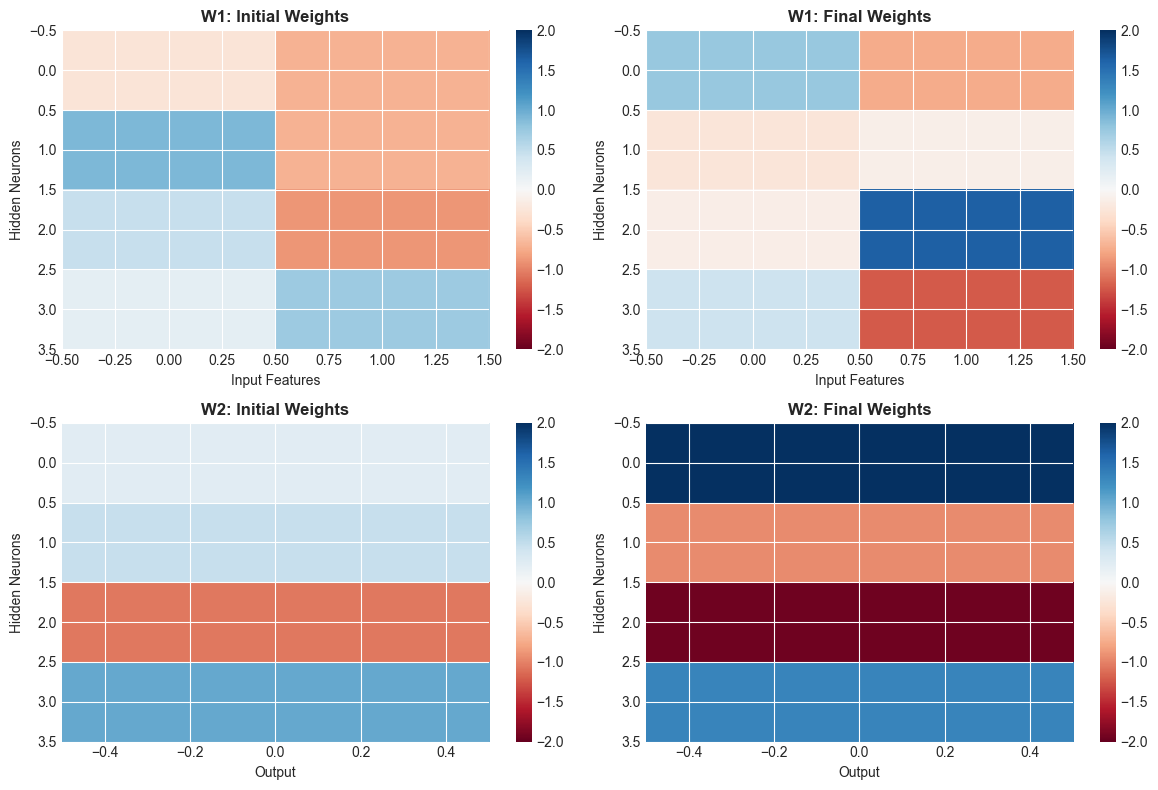


🎯 Notice how the weights changed to solve the classification problem!
This is the magic of backpropagation - it automatically finds the right parameters!


In [23]:
# Final demonstration: Let's see how weight changes during training
print("=== WEIGHT EVOLUTION ANALYSIS ===")

# Compare initial vs final weights
print("Weight changes during training:")
print(f"W1 initial range: [{W1.min():.3f}, {W1.max():.3f}]")
print(f"W1 final range:   [{W1_trained.min():.3f}, {W1_trained.max():.3f}]")
print(f"W2 initial range: [{W2.min():.3f}, {W2.max():.3f}]")
print(f"W2 final range:   [{W2_trained.min():.3f}, {W2_trained.max():.3f}]")

# Visualize weight changes
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

# Initial weights
im1 = ax1.imshow(W1.T, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
ax1.set_title('W1: Initial Weights', fontweight='bold')
ax1.set_xlabel('Input Features')
ax1.set_ylabel('Hidden Neurons')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(W1_trained.T, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
ax2.set_title('W1: Final Weights', fontweight='bold')
ax2.set_xlabel('Input Features')
ax2.set_ylabel('Hidden Neurons')
plt.colorbar(im2, ax=ax2)

im3 = ax3.imshow(W2, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
ax3.set_title('W2: Initial Weights', fontweight='bold')
ax3.set_xlabel('Output')
ax3.set_ylabel('Hidden Neurons')
plt.colorbar(im3, ax=ax3)

im4 = ax4.imshow(W2_trained, cmap='RdBu', aspect='auto', vmin=-2, vmax=2)
ax4.set_title('W2: Final Weights', fontweight='bold')
ax4.set_xlabel('Output')
ax4.set_ylabel('Hidden Neurons')
plt.colorbar(im4, ax=ax4)

plt.tight_layout()
plt.show()

print("\n🎯 Notice how the weights changed to solve the classification problem!")
print("This is the magic of backpropagation - it automatically finds the right parameters!")